# Examples of running HypoXPy workflow to locate earthquakes
The original event catalog and phase picks are the output of the QuakeFlow with GAMMA associator.

In [1]:
import os, sys,glob
import pandas as pd
import numpy as np
from hypoxpy import HypoInvCore as hypoinvcore
from hypoxpy import HypoDDCore as hypoddcore
from hypoxpy import utils
import matplotlib.pyplot as plt

/usr/local/anaconda3/envs/hypox/lib/python3.11/site-packages/obspy/core/util/base.py:26: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


## 1. Setup key driving parameters

In [ ]:
# modified from https://github.com/YijianZhou/Hypo-Interface-Py
binpath='/Users/xtyang/bin' #path to hypoDD binaries.
indir='input'
outdir='output'
if not os.path.exists(outdir):
    os.makedirs(outdir)
namebase='GAMMA'

"""
Data files
"""
station_file=os.path.join(indir,'GAMMA_station_list.json')
station_file_hypoinv=os.path.join(indir,'GAMMA_station_hypoinv.dat')
station_file_hypodd=os.path.join(indir,'GAMMA_station_hypodd.dat')

event_file=os.path.join(indir,'GAMMA_catalog.csv')
phase_file=os.path.join(indir,'GAMMA_picks.csv') #input original phase file.
phase_file_reformat_hypoinv=f'{indir}/{namebase}_phase_hypoinv.pha' #output reformatted phase file for hypoDD.
phase_file_reformat_hypodd=f'{indir}/{namebase}_phase_hypodd.pha' #output reformatted phase file for hypoDD.

#final catalogs
#file names for the final summary catalogs.
out_hypoinv_bad = '%s/%s_hypoinv_bad.csv'%(outdir,namebase)
out_hypoinv_good = '%s/%s_hypoinv_good.csv'%(outdir,namebase)
out_hypodd_final = '%s/%s_hypodd_catalog.csv'%(outdir,namebase)

evid_label='event_id' #column name for event ID in the input event and pick files.
mapping_evid=True #whether to remap event IDs to integers starting from 1 for HypoDD compatibility.
        #If False, original event IDs are used (may cause issues if IDs are not integers or not starting from 1).
        #THIS SHOULD BE TRUE, UNLESS YOU ARE SURE YOUR EVENT IDS ARE INTEGERS STARTING FROM 1.
if mapping_evid:
      evid_label_mapped=evid_label + "_mapped" #this will be used only if mapping_evid is True.
else:
      evid_label_mapped = evid_label

evid_label_mapped = 'event_id_mapped'
save_cleaned_data=True #whether to save cleaned event and pick data after removing invalid entries.
        #THIS SHOULD BE TRUE IF mapping_evid IS TRUE. IT IS SET AUTOMATICALLY IN THE FUNCTION IF mapping_evid IS TRUE.
cleaned_eventfile = os.path.splitext(event_file)[0] + "_cleaned.csv"
cleaned_pickfile = os.path.splitext(phase_file)[0] + "_cleaned.csv"

# combine network and station for HypoDD format.
combine_net_sta=True
cleanup=False #remove intermediate files from each relocation run if True.
qc_phase=False #QC phase when reformatting. Currently, only check if both P and S are available. Recommend to set to False.

"""
Control parameters for running HypoInverse
"""
pmodel=os.path.join(indir,'velo_p_eg.cre')
smodel=os.path.join(indir,'velo_s_eg.cre')
lat_code='N'
lon_code='W'

depth_try_list=np.arange(0,20.5,0.5)

min_nsta=4 #minimum number of stations to relocate the earthquake. 4 is recommeneded as the minimum to get a reliable location.

"""
Control parameters for running HypoDD
"""
#depth correction for phase file reformatting to avoid air quakes.
dep_corr = 5  #km, modify velocity model accordingly.

#change the template parameters for more controls on hypodd and ph2dt.
template_par_ph2dt = os.path.join(indir,'template_ph2dt_par.inp')
template_par_hypodd = os.path.join(indir,'template_hypodd_par.inp')



In [3]:
#read station information
stations = utils.stainfo_json2csv(station_file,informat='GAMMA')
print(stations)
# drop duplicates ignoring 'channel'
stations_unique = stations.drop(columns=['channel']).drop_duplicates().reset_index(drop=True)
print(stations_unique)

   network station channel   latitude   longitude  elevation
0       AV    DEER     BHE  54.971270 -162.324370      392.3
1       AV    DEER     BHN  54.971270 -162.324370      392.3
2       AV    DEER     BHZ  54.971270 -162.324370      392.3
3       AV     DOL     BHE  55.149621 -161.864720      453.0
4       AV     DOL     BHN  55.149621 -161.864720      453.0
5       AV     DOL     BHZ  55.149621 -161.864720      453.0
6       AV     DT1     BHE  55.106270 -162.283130      198.0
7       AV     DT1     BHN  55.106270 -162.283130      198.0
8       AV     DT1     BHZ  55.106270 -162.283130      198.0
9       AV     DTN     BHE  55.144800 -162.259000      396.0
10      AV     DTN     BHN  55.144800 -162.259000      396.0
11      AV     DTN     BHZ  55.144800 -162.259000      396.0
12      AV     HAG     SHE  55.316860 -161.904390      515.4
13      AV     HAG     SHN  55.316860 -161.904390      515.4
14      AV     HAG     SHZ  55.316860 -161.904390      515.4
15      AV    PN7A     B

## 2. Reformat station information.
The `hypoxpy.utils.reformat_stainfo_hypoinverse()` function takes input in `json` or `csv` format. You can specify the format as `json-gamma` for json files from running the gamma workflow. See the source code or use `help()` to get detailed usage information of this function. 

* `force_channel_type` option is to force all channels to the specified type. This is because in some earthquake detection and association steps, the original channel types might be lost, making it impossible to link the phase data with station information.
* `rename_component_dict` option is to rename component names. This is needec when some components originally having 1 or 2 in the names. These original names sometimes are not kept through the earthquake detection and association steps.
* `ignore_component` option will ignore the component code and only saves the channel type, e.g., BH instead of BHZ.

Similarly, `hypoxpy.utils.reformat_stainfo_hypodd()` reformats the station file for hypodd. Set `combine_net_sta` to True to carry the network information. Otherwise, only station name will be kept.

In [4]:
utils.reformat_stainfo_hypoinverse(station_file,station_file_hypoinv,informat='json-gamma',ignore_component=False)
print("Reformatted station file for hypoinverse: "+station_file_hypoinv)

utils.reformat_stainfo_hypodd(station_file, station_file_hypodd,informat='json-gamma',combine_net_sta=combine_net_sta) # type: ignore
print("Reformatted station file for hypodd: "+station_file_hypodd)

Reformatted station file for hypoinverse: input/GAMMA_station_hypoinv.dat
Reformatted station file for hypodd: input/GAMMA_station_hypodd.dat


## 3. Run HypoInverse
### 3.1 Convert the phase picks and catalog from GAMMA to Hypoinverse format
The outputs from running GAMMA contain picks and preliminary catalog, while the solutions of locations are poor. This block shows examples of converting or merging the picks and earthquake catalog to phase data format needed by Hypoinverse. We are using Y2000-compatible format here (https://ncedc.org/ftp/pub/doc/ncsn/shadow2000.pdf).

If `qc` is True, only events with both P and S picks will be saved. 
`default_component` here to address the issue that GAMMA picks only have two letters for the channels (only channel type). Use one letter code here to replace the empty component code. If the component code also exists, the `default_component` value will be ignored.

`mapping_evid` re-assign the event id counting from 1.


In [5]:
utils.convert_gamma2hypoinverse(event_file,phase_file,outfile=phase_file_reformat_hypoinv,qc=qc_phase,default_component='Z',verbose=False,
                                evid_label=evid_label,mapping_evid=mapping_evid,evid_label_mapped=evid_label_mapped,save_cleaned_data=save_cleaned_data,
                                cleaned_eventfile=cleaned_eventfile,cleaned_pickfile=cleaned_pickfile)

100%|██████████| 9257/9257 [00:02<00:00, 3403.72it/s]


### 3.2 Driver to run HypoInverse via the HypoInvCore module
Major parameters to run the code are carried through with a container class named `HypoInvCore.HypoInvConfig()`. This class is simplified from the `config()` class in `Hypo-Interface-Py`. In `HypoXPy`, I also reduced the number of metadata/parameters, to focus only on required key parameters.

Examples here use the phase information directly from the `GAMMA` association step. The station information file has been reformated as shown in the previous cell. 

In [6]:
config_hypoinv = hypoinvcore.HypoInvConfig(binpath=binpath,indir=indir,outdir=outdir,phase_file=phase_file_reformat_hypoinv,
                                           station_file=station_file_hypoinv,pmodel=pmodel,smodel=smodel,min_nsta=min_nsta,
                                           namebase=namebase,lat_code=lat_code,lon_code=lon_code,ztrlist=depth_try_list)
print(config_hypoinv)

HypoInvConfig object
--------------------
HYPOINVERSE binary : /Users/xtyang/bin/hyp1.40
Input directory   : input
Output directory  : output
Name base         : GAMMA
Phase file        : input/GAMMA_phase_hypoinv.pha
Station file     : input/GAMMA_station_hypoinv.dat
P velocity model : input/velo_p_eg.cre
S velocity model : input/velo_s_eg.cre
Poisson ratio    : 1.73
Latitude code    : N
Longitude code   : W
Reference elev.  : 0.0
Grid elev.       : 0.0
Initial depths   : [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0]
Min # stations   : 4
RMS weight       : 4 0.3 1 3
Initial dist.    : 1 50 1 2
Dist. weight     : 4 20 1 3
Weight code      : 1 0.6 0.3 0.2
Write PRT file   : False
Write ARC file   : False


### 3.3 Run hypoinverse through the interface
This is the key step to run hypoinverse. I kept the way Hypo-Interface-Py uses running the code on a series of initial depths. This list is specified as `ztrlist` in the configuration step above.

In [7]:
# 1. produce parameter files for each testing initial depth.
hypparfilelist=hypoinvcore.generate_parfile(config_hypoinv,indir,outdir=outdir,magline="MAG 1 T 1 1")

# 2. Run hypoinverse with all parameter files.
config_hypoinv.run(hypparfilelist)

Running /Users/xtyang/bin/hyp1.40 by depth grids: 100%|██████████| 21/21 [00:29<00:00,  1.40s/it]


### 3.4 Extract inversion results based on quality
In `hypoinvconfig.finalize`, you can pass the original event catalog to retrieve the magnitude information. Otherwise, the function will extract the magnitude from the HypoInverse results.

In [8]:
print('converting output sum files')

config_hypoinv.finalize(mag_dict=cleaned_eventfile,evid_label=evid_label_mapped,
                            cleanup=cleanup,out_good=out_hypoinv_good,out_bad=out_hypoinv_bad);

converting output sum files
Earthquakes are saved in:
  output/GAMMA_hypoinv_good.csv (good)
  output/GAMMA_hypoinv_bad.csv (bad)


## 4. Run HypoDD on top of HypoInverse
This step uses the HypoInverse good catalog to reformat the phase for HypoDD.

### 4.1 Reformat phase data
From GAMMA picks (after cleaning) and HypoInverse good catalog. Since the hypoinverse steps have cleaned up the picks and catalog with remapped evid. We will use the `evid_label_mapped` here and the cleaned picks and catalog.

In [9]:
utils.convert_gamma2hypodd(out_hypoinv_good,cleaned_pickfile,outfile=phase_file_reformat_hypodd,
                     combine_net_sta=combine_net_sta,qc=qc_phase,verbose=False,
                     evid_label=evid_label_mapped,mapping_evid=False,save_cleaned_data=False) # 

Converting GAMMA to HypoDD phase file: 100%|██████████| 2887/2887 [00:00<00:00, 3220.87it/s]


### 4.2 Configure and run HypoDD with HypoDDCore module

In [20]:
# -------------------------------
# 2. Configure hypoDD running settings
# -------------------------------
config_hypodd = hypoddcore.HypoDDConfig(binpath=binpath,indir=indir,outdir=outdir,namebase=namebase,
    station_file=station_file_hypodd,phase_file=phase_file_reformat_hypodd,
    hypodd_inp_template=template_par_hypodd,ph2dt_inp_template=template_par_ph2dt)
print(config_hypodd)


HypoDDConfig object
-------------------
HypoDD binary     : /Users/xtyang/bin/hypoDD
ph2dt binary      : /Users/xtyang/bin/ph2dt
Binary base path  : /Users/xtyang/bin
Input directory   : input
Output directory  : output
Name base         : GAMMA
Station file      : input/GAMMA_station_hypodd.dat
Phase file        : input/GAMMA_phase_hypodd.pha
HypoDD template   : input/template_hypodd_par.inp
ph2dt template    : input/template_ph2dt_par.inp
Depth correction  : 5


In [21]:

# -------------------------------
# 3. hypoDD (core relocation)
# -------------------------------
print(f"Running hypoDD flow:")
config_hypodd.run(verbose=True)


Running hypoDD flow:
running ph2dt...
[INFO] ph2dt completed: output/GAMMA.ph2dt
running hypodd...
finished hypoDD flow. Call HypoDDConfig.finalize() to collect the outputs.


### 4.3 Collect output and clean up (if flagged True)

In [22]:
config_hypodd.finalize(out_catalog_file=out_hypodd_final,cleanup=cleanup)

[INFO] Wrote output catalog: output/GAMMA_hypodd_catalog.csv with 2435 events.


time   latitude   longitude  depth_km  magnitude  \
0     2021-01-03T12:41:26.150000  54.967322 -162.290658      5.82       1.77   
1     2021-02-03T21:42:16.680000  55.067721 -161.602035     15.71       0.66   
2     2021-02-03T22:08:43.760000  55.318136 -161.751888      1.70       0.21   
3     2021-02-03T22:17:17.640000  55.322506 -161.335742     17.00       1.26   
4     2021-02-04T12:19:23.690000  54.832190 -162.661149     26.82       1.97   
...                          ...        ...         ...       ...        ...   
2430  2021-02-03T08:32:09.010000  55.055518 -161.743343     12.83       1.52   
2431  2021-02-03T09:02:58.450000  54.564937 -162.365088     53.76       1.62   
2432  2021-01-03T12:41:27.680000  55.502877 -161.900716     32.01       2.31   
2433  2021-02-03T15:36:28.310000  55.072750 -161.171126     27.88       1.77   
2434  2021-02-03T17:35:48.860000  54.559932 -161.266374      8.99       1.73   

     event_id  
0         100  
1        1001  
2        1002  
3        1003  
4        1020  
...       ...  
2430      984  
2431      985  
2432       99  
2433      993  
2434      998  

[2435 rows x 6 columns]

### 4.4 Read and plot the earthquakes after HypoDD locations
Plot earthquakes scaled by magnitude and colored by depth

In [23]:
quakes_original=pd.read_csv(cleaned_eventfile)
quakes_hypoinv=pd.read_csv(out_hypoinv_good)
quakes_hypodd=pd.read_csv(out_hypodd_final)

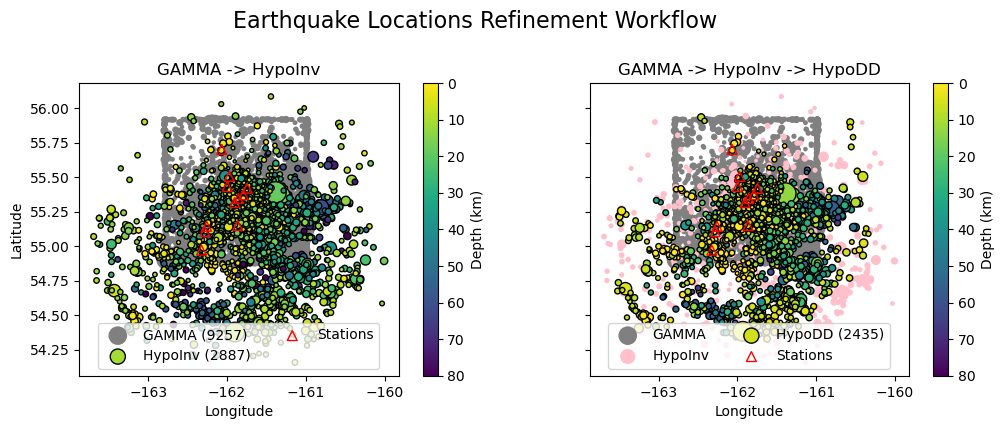

In [24]:
size_scale = 5
# define min/max depth for color scale (km)
depth_min = 0
depth_max = 80


fig, axes = plt.subplots(1, 2, figsize=(11, 4), sharey=True)
mean_lat = np.mean(
    np.concatenate([quakes_original.latitude.values,
                    quakes_hypoinv.latitude.values,
                    quakes_hypodd.latitude.values])
)

for ax in axes:
    ax.set_aspect(1 / np.cos(np.deg2rad(mean_lat)))

# ---------- Panel 1: GAMMA -> HypoInv ----------
ax = axes[0]
ax.scatter(quakes_original.longitude, quakes_original.latitude,
           size_scale * np.power(2, quakes_original.magnitude),
           facecolors='0.5', edgecolors='none', label='GAMMA (%d)'%(len(quakes_original)))
sc1 = ax.scatter(quakes_hypoinv.longitude, quakes_hypoinv.latitude,
                 size_scale * np.power(2, quakes_hypoinv.magnitude),
                 quakes_hypoinv.depth_km,edgecolors='k', cmap='viridis_r', 
                 vmin=depth_min, vmax=depth_max, label='HypoInv (%d)'%(len(quakes_hypoinv)))
cbar1 = fig.colorbar(sc1, ax=ax, label='Depth (km)')
cbar1.ax.invert_yaxis()

#plot stations
ax.scatter(stations_unique.longitude,stations_unique.latitude,
           marker='^', facecolors='none',edgecolors='r', s=50, label='Stations')
ax.set_title('GAMMA -> HypoInv')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend(loc='lower center',ncol=2)

# ---------- Panel 2: GAMMA -> HypoInv -> HypoDD ----------
ax = axes[1]
ax.scatter(quakes_original.longitude, quakes_original.latitude,
           size_scale * np.power(2, quakes_original.magnitude),
           facecolors='0.5', edgecolors='none', label='GAMMA')
ax.scatter(quakes_hypoinv.longitude, quakes_hypoinv.latitude,
           size_scale * np.power(2, quakes_hypoinv.magnitude),
           facecolors='pink', edgecolors='none', label='HypoInv')
sc2 = ax.scatter(quakes_hypodd.longitude, quakes_hypodd.latitude,
                 size_scale * np.power(2, quakes_hypodd.magnitude),
                 quakes_hypodd.depth_km,edgecolors='k', cmap='viridis_r', 
                 vmin=depth_min, vmax=depth_max, label='HypoDD (%d)'%(len(quakes_hypodd)))
cbar2 = fig.colorbar(sc2, ax=ax, label='Depth (km)')
cbar2.ax.invert_yaxis()
#plot stations
ax.scatter(stations_unique.longitude,stations_unique.latitude,
           marker='^', facecolors='none',edgecolors='r', s=50, label='Stations')
ax.set_title('GAMMA -> HypoInv -> HypoDD')
ax.set_xlabel('Longitude')
ax.legend(loc='lower center',ncol=2)

plt.suptitle('Earthquake Locations Refinement Workflow', fontsize=16, y=1.03)
plt.tight_layout()
plt.show()
